<a href="https://colab.research.google.com/github/pseudo-xy/pseudo-xy/blob/main/neural%20net%20model%20on%20the%20spotify%20datatset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
upload = files.upload()

Saving spotify.csv to spotify.csv


In [2]:
import pandas as pd
spotify = pd.read_csv('spotify.csv')
spotify.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [4]:

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_numerical = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_categorical = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_numerical),
    (OneHotEncoder(), features_categorical),
)

# to prevent leakage, a 'grouped' split is done to keep all of an artist's 
# songs in one. 
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


Minimum Validation Loss: 0.1966


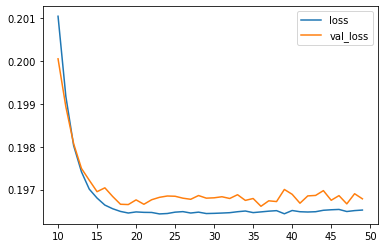

In [6]:
# trying a linear neural model on the dataset
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

model underfitting

Epoch 1/50
49/49 [==============================] - 3s 19ms/step - loss: 0.2334 - val_loss: 0.2069
Epoch 2/50
49/49 [==============================] - 0s 6ms/step - loss: 0.2025 - val_loss: 0.2012
Epoch 3/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1977 - val_loss: 0.1993
Epoch 4/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1945 - val_loss: 0.1984
Epoch 5/50
49/49 [==============================] - 0s 7ms/step - loss: 0.1922 - val_loss: 0.1988
Epoch 6/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1901 - val_loss: 0.1976
Epoch 7/50
49/49 [==============================] - 0s 7ms/step - loss: 0.1887 - val_loss: 0.1968
Epoch 8/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1877 - val_loss: 0.1959
Epoch 9/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1869 - val_loss: 0.1980
Epoch 10/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1854 - val_loss: 0.1978
Epoch 11/50
49/49 

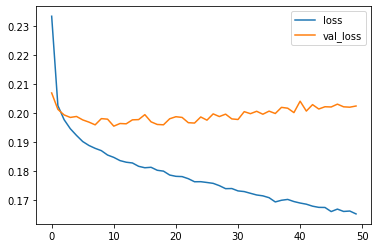

In [7]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

validation loss seems to increase a little but the training loss keeps decreasing, this indicates a beginning of an overfit. reducing the number of units to make the model wider or implementing an early stopping could stop this

In [9]:
# implementing an early_stoppinng
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True)

Epoch 1/50
49/49 [==============================] - 2s 13ms/step - loss: 0.2351 - val_loss: 0.2053
Epoch 2/50
49/49 [==============================] - 0s 6ms/step - loss: 0.2027 - val_loss: 0.2006
Epoch 3/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1971 - val_loss: 0.1981
Epoch 4/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1940 - val_loss: 0.1973
Epoch 5/50
49/49 [==============================] - 0s 7ms/step - loss: 0.1917 - val_loss: 0.1958
Epoch 6/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1896 - val_loss: 0.1959
Epoch 7/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1883 - val_loss: 0.1960
Epoch 8/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1877 - val_loss: 0.1957
Epoch 9/50
49/49 [==============================] - 0s 7ms/step - loss: 0.1861 - val_loss: 0.1974
Epoch 10/50
49/49 [==============================] - 0s 7ms/step - loss: 0.1858 - val_loss: 0.1966
Minimum Validation

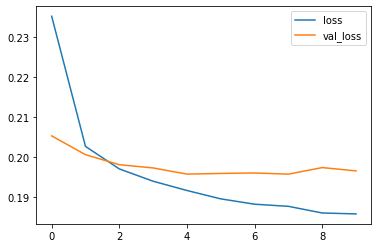

In [10]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));